# マルチモーダル検索のデモノートブック
埋め込みモデル：Cohere Embed Multilingual v 3.0

In [38]:
import cohere
from pathlib import Path
from PIL import Image
from io import BytesIO
import base64
import os
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import gradio as gr

### ヘルパー関数の定義

In [39]:
# 類似度（コサイン）計算関数
def calculate_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [40]:
# 画像をData URLに変換する関数を定義
def image_to_base64_data_url(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    data_url = f"data:image/jpeg;base64,{img_base64}"
    return data_url

In [41]:
# 結果表示用の Gradio インターフェースを生成する関数
def create_search_interface(query_type, query, max_images, results_df, max_image_width=None, max_image_height=None):
    """
    検索結果を表示するためのGradioインターフェイスを作成する。
    
    Parameters:
        query_type (str): "画像"  or "テキスト"
        query: 画像ファイルへのパスまたはテキスト文字列
        max_images (int): 表示する結果の最大数
        results_df (pd.DataFrame): DataFrame  'テキスト', 'パス', '類似度' の3カラムが必要
        max_image_width (int, optional): 表示する画像の最大幅
        max_image_height (int, optional): 表示する画像の最大高さ
    
    Returns:
        gr.Blocks: 検索結果を表示するGradioインターフェース
    """
    
    # 表示する画像数を max_images に制限
    results_df = results_df.head(max_images).reset_index(drop=True)
    
    with gr.Blocks() as demo:
        # 検索クエリを表示
        if query_type == "画像":
            gr.Markdown("### 検索クエリ（画像）")
            gr.Image(value=query, width=max_image_width, height=max_image_height)
        else:
            gr.Markdown("### 検索クエリ（テキスト）")
            gr.Textbox(value=query, label="")
        
        gr.Markdown("### 検索結果")
        
        for i, row in results_df.iterrows():
            with gr.Group():
                with gr.Row():
                    # 順位表示用左カラム
                    with gr.Column(scale=1, min_width=50):
                        #gr.Markdown(f"**#{i+1}**")
                        gr.Markdown(f"<h2 style='font-size: 24px; margin: 0;'>#{i+1}</h2>")
                    
                    # コンテンツ（画像および/またはテキスト）用の中央カラム
                    with gr.Column(scale=5):
                        # パスが存在し、画像ファイルである場合に表示
                        path = row['パス']
                        if path is not None and os.path.exists(path) and path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                            gr.Image(value=path, width=max_image_width, height=max_image_height)
                        
                        # テキストが存在する場合に表示
                        if row['テキスト']:
                            gr.Textbox(value=row['テキスト'], label="", lines=3)
                    
                    # 右列は類似性とパス
                    with gr.Column(scale=4):
                        gr.Number(value=row['類似度'], label="類似度")
                        gr.Textbox(value=row['パス'], label="パス", lines=1)
                
                # 結果の間にセパレータを追加
                gr.Markdown("---")
    
    return demo

# 使用例（テキストによる画像などの検索の結果表示）:
# result_display = create_search_interface(query_type="テキスト", query="Cohereって何ですか？", max_images=12, results_df=results_df, max_image_width=400, max_image_height=300)
# result_display.launch() # Gradio サーバーを起動
# results_display.close() # Gradio サーバーを停止（忘れずに！）
# 使用例（画像による画像などの検索の結果表示）:
# result_display = create_search_interface(query_type="画像", query="images/something_greate.jpg", max_images=12, results_df=results_df, max_image_width=400, max_image_height=300)
# result_display.launch() # Gradio サーバーを起動
# results_display.close() # Gradio サーバーを停止（忘れずに！）

## 画像の埋め込み生成

### Cohere クライアントオブジェクトの生成

In [42]:
_= load_dotenv(find_dotenv())
api_key = os.getenv("COHERE_API_KEY")
co = cohere.Client(api_key=api_key)

### 埋め込み処理対象の画像群を定義

In [43]:
image_dir = "images"
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']
image_names = []
for filename in os.listdir(image_dir):
    if any(filename.lower().endswith(ext.lower()) for ext in image_extensions):
        image_names.append(filename)
image_paths = [os.path.join(image_dir, name) for name in image_names]
image_paths

['images\\DSC_0385-2.jpg',
 'images\\sample02.jpg',
 'images\\sample09.jpg',
 'images\\00387-4109315140.png',
 'images\\DSC_0046.JPG',
 'images\\DSCF2958.JPG',
 'images\\ComfyUI_00021_.png',
 'images\\DSC_0060.JPG',
 'images\\sample03.jpg',
 'images\\DSC_5382.JPG',
 'images\\DSC_5349.JPG',
 'images\\1517975029190.jpg',
 'images\\DSC_3430.JPG',
 'images\\DSC_3476.JPG']

### 画像の埋め込み生成の実行

In [44]:
doc_embeddings = []
for i, image_path in enumerate(image_paths):
    # 画像をData URLに変換
    processed_image = image_to_base64_data_url(image_path)
    
    # 埋め込みを取得
    ret = co.embed(
        images=[processed_image],
        input_type="image",
        model="embed-multilingual-v3.0",
        embedding_types=["float"],        
    )
    
    doc_embeddings.append({
        "text": None,
        "path": image_path,
        "embedding": ret.embeddings.float[0]
    })
    print(f"画像 {i+1}/{len(doc_embeddings)} の処理が完了しました: {image_path}")

画像 1/1 の処理が完了しました: images\DSC_0385-2.jpg
画像 2/2 の処理が完了しました: images\sample02.jpg
画像 3/3 の処理が完了しました: images\sample09.jpg
画像 4/4 の処理が完了しました: images\00387-4109315140.png
画像 5/5 の処理が完了しました: images\DSC_0046.JPG
画像 6/6 の処理が完了しました: images\DSCF2958.JPG
画像 7/7 の処理が完了しました: images\ComfyUI_00021_.png
画像 8/8 の処理が完了しました: images\DSC_0060.JPG
画像 9/9 の処理が完了しました: images\sample03.jpg
画像 10/10 の処理が完了しました: images\DSC_5382.JPG
画像 11/11 の処理が完了しました: images\DSC_5349.JPG
画像 12/12 の処理が完了しました: images\1517975029190.jpg
画像 13/13 の処理が完了しました: images\DSC_3430.JPG
画像 14/14 の処理が完了しました: images\DSC_3476.JPG


## 画像検索（1） - テキストをクエリーとした画像の検索

### テキストクエリーの埋め込み生成

In [45]:
#query = ["猫と散歩する女の子"]
query = ["東京駅"]
#query = ["おみくじ"]

In [46]:
ret = co.embed(
    texts=query,
    input_type="search_query",
    model="embed-multilingual-v3.0",
    embedding_types=["float"],
)
query_embedding = ret.embeddings.float

In [47]:
print(f"クエリーテキストの埋め込みの次元数: {len(query_embedding[0])}")

クエリーテキストの埋め込みの次元数: 1024


### テキストクエリーによる画像検索の実行

In [48]:
# クエリと文書の埋め込みベクトル間の類似度を計算
similarities = []
for i in range(len(doc_embeddings)):
    similarity = calculate_similarity(query_embedding[0], doc_embeddings[i]["embedding"])
    similarities.append(similarity)

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'テキスト':None,
    'パス': [doc["path"] for doc in doc_embeddings],
    '類似度': similarities
})

# 類似度の降順でソート
results_df = results_df.sort_values('類似度', ascending=False).reset_index(drop=True)

# 結果を整形して表示
pd.set_option('display.float_format', '{:.4f}'.format)
display(results_df.style.set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
            {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
            {'selector': 'td', 'props': [('padding', '5px')]}
        ]))

,テキスト,パス,類似度
0,None,images\DSC_5382.JPG,0.503662
1,None,images\DSC_5349.JPG,0.414816
2,None,images\DSC_3430.JPG,0.405004
3,None,images\DSC_0046.JPG,0.381377
4,None,images\00387-4109315140.png,0.354084
5,None,images\DSC_0385-2.jpg,0.349925
6,None,images\DSC_3476.JPG,0.345835
7,None,images\DSC_0060.JPG,0.345457
8,None,images\sample03.jpg,0.303927
9,None,images\sample09.jpg,0.288468


In [49]:
# 検索結果を画像付きで表示（最大12枚）
results_display = create_search_interface(query_type = "テキスト", query = query[0], max_images = 12, results_df = results_df, max_image_width=400, max_image_height=300)
results_display.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [50]:
# Gradio サーバーを停止
results_display.close()

Closing server running on port: 7861


## 画像検索（2） - 画像をクエリーとした画像の検索

### クエリー画像の埋め込み生成

#### クエリー画像の定義

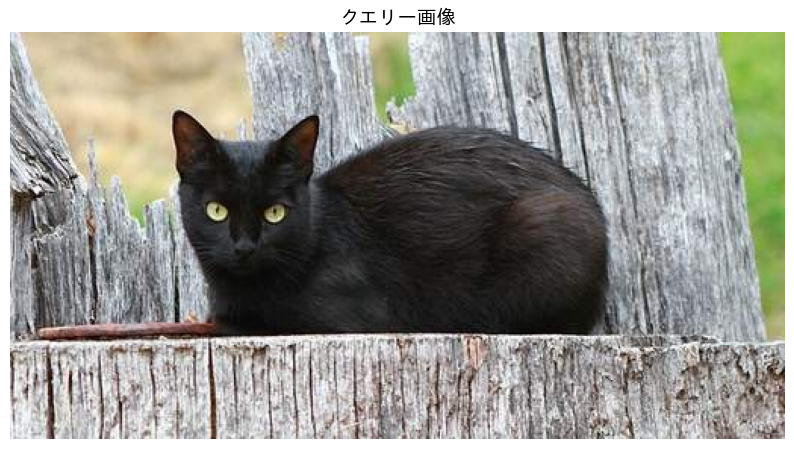

In [51]:
query_image_path = Path("images/sample02.jpg").as_posix()
img = Image.open(query_image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"クエリー画像", fontweight='bold', fontsize=14)
plt.axis('off')
plt.show()

#### クエリー画像の埋め込み処理

In [55]:
processed_image = image_to_base64_data_url(query_image_path)
ret = co.embed(
    images=[processed_image],
    input_type="image",
    model="embed-multilingual-v3.0",
    embedding_types=["float"],
)
query_embedding = ret.embeddings.float

In [56]:
print(f"クエリー画像の埋め込みの次元数: {len(query_embedding[0])}")

クエリー画像の埋め込みの次元数: 1024


### クエリー画像による画像検索の実行

In [59]:
# クエリと文書の埋め込みベクトル間の類似度を計算
similarities = []
for i in range(len(doc_embeddings)):
    similarity = calculate_similarity(query_embedding[0], doc_embeddings[i]["embedding"])
    similarities.append(similarity)

# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'テキスト': None,
    'パス': [doc["path"] for doc in doc_embeddings],
    '類似度': similarities
})

# 類似度の降順でソート
results_df = results_df.sort_values('類似度', ascending=False).reset_index(drop=True)

# 結果を整形して表示
pd.set_option('display.float_format', '{:.4f}'.format)
display(results_df.style.set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
            {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
            {'selector': 'td', 'props': [('padding', '5px')]}
        ]))

,テキスト,パス,類似度
0,None,images\sample02.jpg,1.000000
1,None,images\DSC_0385-2.jpg,0.573187
2,None,images\DSCF2958.JPG,0.570783
3,None,images\sample09.jpg,0.498959
4,None,images\DSC_3430.JPG,0.415847
5,None,images\00387-4109315140.png,0.412501
6,None,images\1517975029190.jpg,0.377901
7,None,images\DSC_3476.JPG,0.345671
8,None,images\DSC_5349.JPG,0.312486
9,None,images\DSC_0060.JPG,0.296960


In [62]:
# 検索結果を画像付きで表示
results_display = create_search_interface(query_type = "画像", query = query_image_path, max_images = 5, results_df = results_df, max_image_width=400, max_image_height=300)
results_display.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [63]:
# Gradio サーバーを停止
results_display.close()

Closing server running on port: 7861


## 画像検索（3） - テキストをクエリーとした画像とテキストのミックス検索
検索対象の画像群はこれまでと同じです。

### 検索対象のテキスト群を定義

In [64]:
texts = [
    '黒猫',
    '三毛猫',
    '猫の神秘的な世界：猫は古来より、その優雅さと神秘性で人々を魅了してきました。そのしなやかな動きと鋭い感覚は、まるで彼らは別世界からの使者であるかのように感じさせます。猫の大きな瞳は、暗闇でも光を捉え、彼らの足音は驚くほど静かです。彼らは独立心が強く、時には気まぐれな行動で私たちを驚かせますが、その愛くるしい姿は多くの人を虜にしています。猫の毛並みに太陽の光が当たるとき、それはまるで黄金に輝く宝物のように美しく、彼らの存在は私たちの日常に小さな魔法をもたらします。猫と暮らすことは、予測不可能で魅惑的な旅へと誘うのです。',
    '猫と人間の特別な絆：猫と人間の関係は、古代エジプト時代から特別なものとして知られています。彼らは神々の象徴として崇められ、幸運と繁栄をもたらす存在として大切にされてきました。現代においても、猫は私たちにとってかけがえのない家族の一員です。彼らは私たちの膝の上で丸くなり、柔らかな毛並みで心を癒やしてくれます。猫の穏やかな鳴き声や、優しい触れ合いは、ストレスフルな日常から私たちを解放し、安らぎを与えてくれます。猫と人間の絆は、言葉を超えた深い信頼と愛情で結ばれているのです。朝、彼らの小さな肉球が顔を優しくタッチする瞬間は、1日の始まりを幸せな気持ちにしてくれます。',
    '猫の驚くべき能力：猫は優れた身体能力と知性を持つ生き物です。彼らは驚異的なバランス感覚を持ち、狭い場所や高い場所を自由自在に動き回ります。猫のジャンプ力は並外れており、高い壁や木の上へと軽々と飛び乗ります。さらに、彼らの狩猟本能は鋭く、獲物となる小動物を正確に追跡します。猫の聴覚と嗅覚も非常に優れており、微かな音や匂いを逃しません。また、猫は直感力に優れ、危険を察知する能力にも長けています。その俊敏さと知性は、私たちを度々驚かせ、彼らの能力に感嘆の声を上げることでしょう。猫の持つ能力は、私たち人間にとって学ぶべき点が多くあるかもしれません。',
    '黒猫が横切ることに関する言い伝えには、不吉な前兆であるという迷信と、幸せを運ぶ福猫であるという言い伝えがあります。',
    '古代エジプトでは、猫は神々しく神聖な動物として崇められ、特に黒猫は豊穣と幸運の象徴とされていました。しかし、ギリシャ・ローマ時代になると、猫、特に黒猫は闇や死と関連付けられるようになります。この時代の人々は、黒猫を不吉な存在や魔女の使いの動物と捉えるようになり、黒猫が横切ることを悪い予兆と考えるようになりました。この時代の迷信や伝承が後世に伝わり、黒猫へのネガティブなイメージが定着したと考えられています。',
    'COVID-19は、SARS-CoV-2（新型コロナウイルス）によって引き起こされる感染症です。2019年12月に最初に確認され、その後、世界的なパンデミックとなりました。症状としては、発熱、咳、息切れ、倦怠感、嗅覚や味覚の喪失などがあります。また、感染経路は、主に飛沫感染と接触感染ですが、空気感染の可能性もあります。高齢者や基礎疾患のある方は重症化リスクが高く、死亡率も高いとされています。COVID-19に対しては、ワクチン接種や手洗い、マスク着用、ソーシャルディスタンスなどの予防措置が推奨されています。パンデミックは世界中の医療システムや経済に大きな影響を与えました。',
    '近似最近傍検索は、高次元空間内で与えられたクエリポイントに最も近い（最も類似した）データポイントを効率的に見つけるアルゴリズムです。',
    '「犬も歩けば棒に当たる」は、日本のことわざの一つで、どんな人でも行動すれば、思いがけない幸運や利益に巡り合う機会があることを意味します。つまり、何もしなければ何も起こらないが、行動を起こせば良いことも悪いことも起こり得るという人生の教訓を表しています。このことわざは、努力をすることや行動することの大切さを教えるときに使われることが多く、チャンスは自ら掴み取るものだというメッセージが込められています。',
    '秋田犬は、日本原産の大型犬種で、忠誠心と勇敢さで知られる人気の犬種です。',
    '自動車の発明はフランス、ドイツ、イギリス、アメリカなど、複数の国で並行して進められ、それぞれの発明家や技術者が独自のアイデアや技術を競い合いながら、現代の自動車へと繋がる発明を成し遂げました。自動車の歴史は、国境を越えた知恵と技術の集積によって織りなされてきたのです。'
]

### 検索対象テキスト群の埋め込みの生成

In [65]:
# 埋め込みを取得
ret = co.embed(
    texts=texts,
    input_type="search_document", # 検索対象のテキストドキュメント
    model="embed-multilingual-v3.0",
    embedding_types=["float"],        
)

# 各テキストとその埋め込みを対応付けてdoc_embeddingsに格納
for i, (text, embedding) in enumerate(zip(texts, ret.embeddings.float)):
    doc_embeddings.append({
        "text": text,
        "path": None,
        "embedding": embedding
    })
    print(f"テキスト {i+1}/{len(texts)} の処理が完了しました: {text[:50]}")

テキスト 1/12 の処理が完了しました: 黒猫
テキスト 2/12 の処理が完了しました: 三毛猫
テキスト 3/12 の処理が完了しました: 猫の神秘的な世界：猫は古来より、その優雅さと神秘性で人々を魅了してきました。そのしなやかな動きと鋭い
テキスト 4/12 の処理が完了しました: 猫と人間の特別な絆：猫と人間の関係は、古代エジプト時代から特別なものとして知られています。彼らは神々
テキスト 5/12 の処理が完了しました: 猫の驚くべき能力：猫は優れた身体能力と知性を持つ生き物です。彼らは驚異的なバランス感覚を持ち、狭い場
テキスト 6/12 の処理が完了しました: 黒猫が横切ることに関する言い伝えには、不吉な前兆であるという迷信と、幸せを運ぶ福猫であるという言い伝
テキスト 7/12 の処理が完了しました: 古代エジプトでは、猫は神々しく神聖な動物として崇められ、特に黒猫は豊穣と幸運の象徴とされていました。
テキスト 8/12 の処理が完了しました: COVID-19は、SARS-CoV-2（新型コロナウイルス）によって引き起こされる感染症です。20
テキスト 9/12 の処理が完了しました: 近似最近傍検索は、高次元空間内で与えられたクエリポイントに最も近い（最も類似した）データポイントを効
テキスト 10/12 の処理が完了しました: 「犬も歩けば棒に当たる」は、日本のことわざの一つで、どんな人でも行動すれば、思いがけない幸運や利益に
テキスト 11/12 の処理が完了しました: 秋田犬は、日本原産の大型犬種で、忠誠心と勇敢さで知られる人気の犬種です。
テキスト 12/12 の処理が完了しました: 自動車の発明はフランス、ドイツ、イギリス、アメリカなど、複数の国で並行して進められ、それぞれの発明家


In [66]:
# doc_embeddingsをDataFrameに変換
df = pd.DataFrame(doc_embeddings)

df['embedding_length'] = df['embedding'].apply(len)
df_display = df[['text', 'path', 'embedding_length']].copy()

# DataFrameの表示
display(df_display)

,text,path,embedding_length
0,None,images\DSC_0385-2.jpg,1024
1,None,images\sample02.jpg,1024
2,None,images\sample09.jpg,1024
3,None,images\00387-4109315140.png,1024
4,None,images\DSC_0046.JPG,1024
5,None,images\DSCF2958.JPG,1024
6,None,images\ComfyUI_00021_.png,1024
7,None,images\DSC_0060.JPG,1024
8,None,images\sample03.jpg,1024
9,None,images\DSC_5382.JPG,1024


### クエリーテキストの埋め込み生成

In [67]:
query = ["猫と散歩する女の子"]
#query = ["おみくじ"]

In [68]:
ret = co.embed(
    texts=query,
    input_type="search_query",
    model="embed-multilingual-v3.0",
    embedding_types=["float"],
)
query_embedding = ret.embeddings.float

In [69]:
print(f"クエリーテキストの埋め込みの次元数: {len(query_embedding[0])}")

クエリーテキストの埋め込みの次元数: 1024


### クエリーテキストによる画像検索の実行

In [70]:
# クエリと文書の埋め込みベクトル間の類似度を計算
similarities = []
for i in range(len(doc_embeddings)):
    similarity = calculate_similarity(query_embedding[0], doc_embeddings[i]["embedding"])
    similarities.append(similarity)
    
# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'テキスト': [doc.get("text", "")[:300] + "..." if doc.get("text", "") and len(doc.get("text", "")) > 300 else doc.get("text", "") for doc in doc_embeddings],
    'パス': [doc.get("path", "") for doc in doc_embeddings],
    '類似度': similarities
})

# 類似度の降順でソート
results_df = results_df.sort_values('類似度', ascending=False).reset_index(drop=True)

# 結果を整形して表示
pd.set_option('display.float_format', '{:.4f}'.format)
display(results_df.style.set_properties(**{
        'text-align': 'left',
        #'white-space': 'nowrap',
        'overflow': 'hidden',
        'text-overflow': 'ellipsis',
        'max-width': '500px'  # テキスト列の最大幅を指定
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
        {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
        {'selector': 'td', 'props': [('padding', '5px')]},
        {'selector': 'td:nth-child(1)', 'props': [('max-width', '400px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis')]}  # テキスト列に特定のスタイルを適用
    ]))

,テキスト,パス,類似度
0,None,images\00387-4109315140.png,0.643601
1,猫の神秘的な世界：猫は古来より、その優雅さと神秘性で人々を魅了してきました。そのしなやかな動きと鋭い感覚は、まるで彼らは別世界からの使者であるかのように感じさせます。猫の大きな瞳は、暗闇でも光を捉え、彼らの足音は驚くほど静かです。彼らは独立心が強く、時には気まぐれな行動で私たちを驚かせますが、その愛くるしい姿は多くの人を虜にしています。猫の毛並みに太陽の光が当たるとき、それはまるで黄金に輝く宝物のように美しく、彼らの存在は私たちの日常に小さな魔法をもたらします。猫と暮らすことは、予測不可能で魅惑的な旅へと誘うのです。,None,0.596759
2,黒猫,None,0.554832
3,猫と人間の特別な絆：猫と人間の関係は、古代エジプト時代から特別なものとして知られています。彼らは神々の象徴として崇められ、幸運と繁栄をもたらす存在として大切にされてきました。現代においても、猫は私たちにとってかけがえのない家族の一員です。彼らは私たちの膝の上で丸くなり、柔らかな毛並みで心を癒やしてくれます。猫の穏やかな鳴き声や、優しい触れ合いは、ストレスフルな日常から私たちを解放し、安らぎを与えてくれます。猫と人間の絆は、言葉を超えた深い信頼と愛情で結ばれているのです。朝、彼らの小さな肉球が顔を優しくタッチする瞬間は、1日の始まりを幸せな気持ちにしてくれます。,None,0.552413
4,猫の驚くべき能力：猫は優れた身体能力と知性を持つ生き物です。彼らは驚異的なバランス感覚を持ち、狭い場所や高い場所を自由自在に動き回ります。猫のジャンプ力は並外れており、高い壁や木の上へと軽々と飛び乗ります。さらに、彼らの狩猟本能は鋭く、獲物となる小動物を正確に追跡します。猫の聴覚と嗅覚も非常に優れており、微かな音や匂いを逃しません。また、猫は直感力に優れ、危険を察知する能力にも長けています。その俊敏さと知性は、私たちを度々驚かせ、彼らの能力に感嘆の声を上げることでしょう。猫の持つ能力は、私たち人間にとって学ぶべき点が多くあるかもしれません。,None,0.547027
5,黒猫が横切ることに関する言い伝えには、不吉な前兆であるという迷信と、幸せを運ぶ福猫であるという言い伝えがあります。,None,0.546924
6,三毛猫,None,0.535740
7,古代エジプトでは、猫は神々しく神聖な動物として崇められ、特に黒猫は豊穣と幸運の象徴とされていました。しかし、ギリシャ・ローマ時代になると、猫、特に黒猫は闇や死と関連付けられるようになります。この時代の人々は、黒猫を不吉な存在や魔女の使いの動物と捉えるようになり、黒猫が横切ることを悪い予兆と考えるようになりました。この時代の迷信や伝承が後世に伝わり、黒猫へのネガティブなイメージが定着したと考えられています。,None,0.520779
8,None,images\DSC_0385-2.jpg,0.492715
9,None,images\DSCF2958.JPG,0.463266


In [73]:
# 検索結果を画像付きで表示
results_display = create_search_interface(query_type = "テキスト", query = query[0], max_images = 12, results_df = results_df, max_image_width=400, max_image_height=300)
gradio_server = results_display.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [74]:
# Gradio サーバーを終了
results_display.close()

Closing server running on port: 7861


## 画像検索（4） - 画像をクエリーとした画像とテキストのミックス検索

### クエリー画像の埋め込み生成

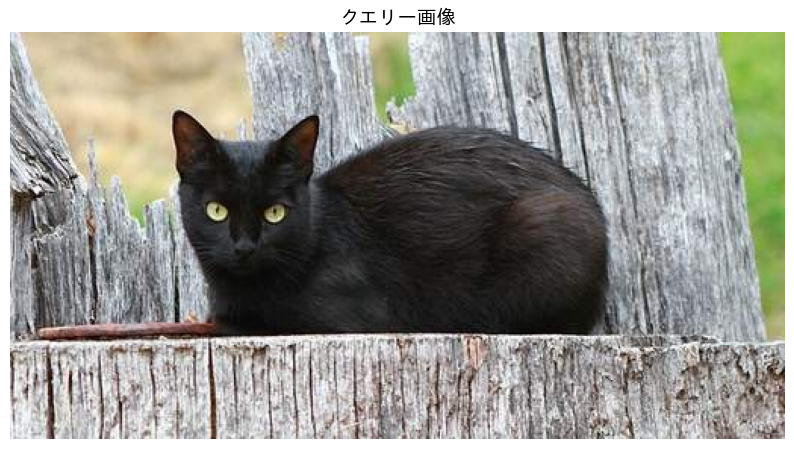

In [75]:
query_image_path = Path("images/sample02.jpg").as_posix()
img = Image.open(query_image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"クエリー画像", fontweight='bold', fontsize=14)
plt.axis('off')
plt.show()

In [76]:
processed_image = image_to_base64_data_url(query_image_path)
ret = co.embed(
    images=[processed_image],
    input_type="image",
    model="embed-multilingual-v3.0",
    embedding_types=["float"],
)
query_embedding = ret.embeddings.float

In [77]:
print(f"クエリーの埋め込みの次元数: {len(query_embedding[0])}")

クエリーの埋め込みの次元数: 1024


### クエリー画像による画像検索の実行

In [78]:
# クエリと文書の埋め込みベクトル間の類似度を計算
similarities = []
for i in range(len(doc_embeddings)):
    similarity = calculate_similarity(query_embedding[0], doc_embeddings[i]["embedding"])
    similarities.append(similarity)
    
# 結果をデータフレームに格納
results_df = pd.DataFrame({
    'テキスト': [doc.get("text", "")[:300] + "..." if doc.get("text", "") and len(doc.get("text", "")) > 300 else doc.get("text", "") for doc in doc_embeddings],
    'パス': [doc.get("path", "") for doc in doc_embeddings],
    '類似度': similarities
})

# 類似度の降順でソート
results_df = results_df.sort_values('類似度', ascending=False).reset_index(drop=True)

# 結果を整形して表示
pd.set_option('display.float_format', '{:.4f}'.format)
display(results_df.style.set_properties(**{
        'text-align': 'left',
        #'white-space': 'nowrap',
        'overflow': 'hidden',
        'text-overflow': 'ellipsis',
        'max-width': '500px'  # テキスト列の最大幅を指定
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
        {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
        {'selector': 'td', 'props': [('padding', '5px')]},
        {'selector': 'td:nth-child(1)', 'props': [('max-width', '400px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis')]}  # テキスト列に特定のスタイルを適用
    ]))

,テキスト,パス,類似度
0,None,images\sample02.jpg,1.000000
1,None,images\DSC_0385-2.jpg,0.573187
2,None,images\DSCF2958.JPG,0.570783
3,黒猫,None,0.518944
4,None,images\sample09.jpg,0.498959
5,黒猫が横切ることに関する言い伝えには、不吉な前兆であるという迷信と、幸せを運ぶ福猫であるという言い伝えがあります。,None,0.481264
6,古代エジプトでは、猫は神々しく神聖な動物として崇められ、特に黒猫は豊穣と幸運の象徴とされていました。しかし、ギリシャ・ローマ時代になると、猫、特に黒猫は闇や死と関連付けられるようになります。この時代の人々は、黒猫を不吉な存在や魔女の使いの動物と捉えるようになり、黒猫が横切ることを悪い予兆と考えるようになりました。この時代の迷信や伝承が後世に伝わり、黒猫へのネガティブなイメージが定着したと考えられています。,None,0.481197
7,三毛猫,None,0.472425
8,猫の神秘的な世界：猫は古来より、その優雅さと神秘性で人々を魅了してきました。そのしなやかな動きと鋭い感覚は、まるで彼らは別世界からの使者であるかのように感じさせます。猫の大きな瞳は、暗闇でも光を捉え、彼らの足音は驚くほど静かです。彼らは独立心が強く、時には気まぐれな行動で私たちを驚かせますが、その愛くるしい姿は多くの人を虜にしています。猫の毛並みに太陽の光が当たるとき、それはまるで黄金に輝く宝物のように美しく、彼らの存在は私たちの日常に小さな魔法をもたらします。猫と暮らすことは、予測不可能で魅惑的な旅へと誘うのです。,None,0.449039
9,猫と人間の特別な絆：猫と人間の関係は、古代エジプト時代から特別なものとして知られています。彼らは神々の象徴として崇められ、幸運と繁栄をもたらす存在として大切にされてきました。現代においても、猫は私たちにとってかけがえのない家族の一員です。彼らは私たちの膝の上で丸くなり、柔らかな毛並みで心を癒やしてくれます。猫の穏やかな鳴き声や、優しい触れ合いは、ストレスフルな日常から私たちを解放し、安らぎを与えてくれます。猫と人間の絆は、言葉を超えた深い信頼と愛情で結ばれているのです。朝、彼らの小さな肉球が顔を優しくタッチする瞬間は、1日の始まりを幸せな気持ちにしてくれます。,None,0.428487


In [81]:
# 検索結果を画像付きで表示
results_display = create_search_interface(query_type = "画像", query = query_image_path, max_images = 12, results_df = results_df, max_image_width=400, max_image_height=300)
gradio_server = results_display.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [80]:
# Gradio サーバーを終了
results_display.close()

Closing server running on port: 7861
